## Modeling - Citation Prediction

In [1]:
# basic
import sys
import os
import json
import pdb
import ast
import time
import requests
from tqdm import tqdm
from collections import Counter, defaultdict, namedtuple

# debug
import pdb
from loguru import logger

import numpy as np
import pandas as pd

# plotting
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

# sklearn
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics
from sklearn.mixture import GaussianMixture as GMM

# regression models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
import xgboost
from xgboost.sklearn import XGBRegressor

# classification models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# from warnings import filterwarnings
# filterwarnings(action='ignore', category=DeprecationWarning,  message='`np.bool` is a deprecated alias')
# filterwarnings(action='ignore', category=DeprecationWarning,  message='`np.int` is a deprecated alias' )
# filterwarnings(action='ignore', category=DeprecationWarning,  message='`np.object` is a deprecated alias')


# custom
from utils import *

SEED = 0

/Users/gautamchoudhary/miniconda3/envs/myenv/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/gautamchoudhary/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Load Data

In [2]:
%%time
YEAR = 2017

works = pd.read_pickle(f'./data/{YEAR}/works.{YEAR}.v2.pkl').set_index('id')
authors = pd.read_pickle(f'./data/{YEAR}/authors.{YEAR}.v2.pkl').set_index('id')
venues = pd.read_pickle(f'./data/{YEAR}/venues.{YEAR}.v2.pkl').set_index('id')
insts = pd.read_pickle(f'./data/{YEAR}/insts.{YEAR}.v2.pkl').set_index('id')

CPU times: user 4.27 s, sys: 1.56 s, total: 5.82 s
Wall time: 6.3 s


In [3]:
%%time
works, authors, venues, insts = preprocess_data(works, YEAR, 2022, authors, venues, insts)

CPU times: user 1.37 s, sys: 259 ms, total: 1.63 s
Wall time: 1.72 s


In [4]:
# Train Test Split: based on `works`
TEST_SIZE = 0.2
train_index, test_index = train_test_split(range(len(works)),
                                           test_size=TEST_SIZE, random_state=SEED)

### Feature Extraction

In [5]:
df = get_features(works, authors, venues, insts, YEAR, N_CLASSES=2, seed=SEED)
df.shape

(135369, 14)

count    135369.000000
mean          2.563881
std           8.177346
min           0.000000
50%           1.000000
90%           6.000000
91%           6.000000
92%           7.000000
93%           7.000000
94%           8.000000
95%          10.000000
96%          11.000000
97%          14.000000
98%          18.000000
99%          29.000000
max         662.000000
Name: y_reg, dtype: float64


<AxesSubplot:xlabel='y_reg', ylabel='Count'>

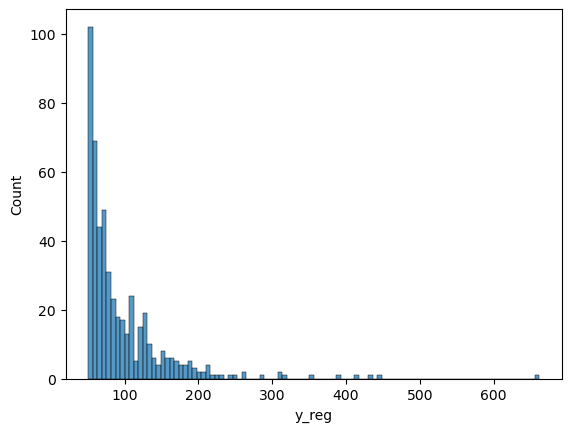

In [6]:
# check distribution of citations - target variable
temp = df['y_reg']
print(temp.describe(percentiles=[i/100 for i in range(90, 100, 1)]))
sns.histplot(temp[temp>50], bins=100)

### GMM - unsupervised clustering

In [7]:
# ref: https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html
# ref: https://towardsdatascience.com/gaussian-mixture-model-clusterization-how-to-select-the-number-of-components-clusters-553bef45f6e4

x = df['y_reg'].to_numpy().reshape(-1, 1)
n_components = np.arange(1, 11)
models = [GMM(n, covariance_type='full', random_state=SEED).fit(x)
          for n in tqdm(n_components)]

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.58it/s]


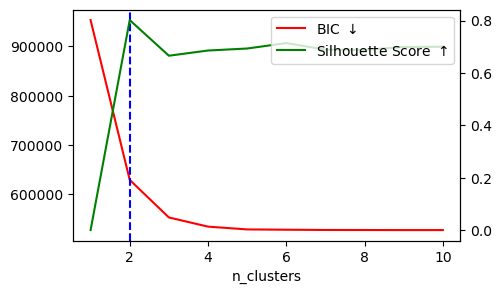

In [9]:
fig, ax = plt.subplots(ncols=1, figsize=(5,3))

# bic score
ax.plot(n_components, [m.bic(x) for m in models], 'r-', label=r'BIC $\downarrow$')
ax.set_xlabel('n_clusters')

# silhouette score
ax1 = ax.twinx()
s = [0] + [metrics.silhouette_score(x, m.predict(x), metric='euclidean', sample_size=1000) for m in models[1:]]
ax1.plot(n_components, s, 'g-', label=r'Silhouette Score $\uparrow$')
ax1.set_xlabel('n_clusters')
fig.legend(loc='upper right', bbox_to_anchor=(1,1), bbox_transform=ax.transAxes)

# optimal cluster line
ax.axvline(2, color = 'b', linestyle='--')